# Text classiﬁcation using Spark

* В данной работе используется pyspark
* В качестве моделей классификации используются **логистическая регрессия** и **случайный лес**
* Для формирования признаков используются **hashingTF + IDF** и **word2Vec**
* Исследовано влияние **numFeatures** для **hashingTF** на точность решения задачи классификации: построены таблицы и графики
* Исследовано влияние **vectorSize** для **word2Vec** на точность решения задачи классификации: построены таблицы и графики
* В качестве метрики классификации используется **roc_auc**

In [1]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
from pyspark.sql.functions import *
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Word2Vec
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, IndexToString
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when, round

import matplotlib.pyplot as plt

# 1. Чтение данных

In [ ]:
df = spark.read.csv("data/train.csv", header=True)
df.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf|Explanation.Why t...|    0|           0|      0|     0|     0|            0|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|
|000113f07ec002fd|Hey man. I'm real...|    0|           0|      0|     0|     0|            0|
|0001b41b1c6bb37e|""".More.I can't ...|    0|           0|      0|     0|     0|            0|
|0001d958c54c6e35|You. sir. are my ...|    0|           0|      0|     0|     0|            0|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
only showing top 5 rows



In [ ]:
df.filter("toxic is NULL").show()

+----------------+--------------------+-----+------------+-------+------+------+-------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+--------------------+-----+------------+-------+------+------+-------------+
|01ce75675a501e50|""\.You wasted yo...| null|        null|   null|  null|  null|         null|
|97d03f44a7e75c5c|""\..To answer  a...| null|        null|   null|  null|  null|         null|
|a24b277041f8f70b|""\.. The Signpos...| null|        null|   null|  null|  null|         null|
|f41eb1c21223e092|""\"""".. OHHHHHH...| null|        null|   null|  null|  null|         null|
|5bb0ad059784ac4c|""\.No. it doesn'...| null|        null|   null|  null|  null|         null|
|87becb6c18ef1fef|""\.. """"Persona...| null|        null|   null|  null|  null|         null|
+----------------+--------------------+-----+------------+-------+------+------+-------------+



По итогу 6 строчек криво распарсились при чтении.

# 2. Подготовка данных

* Приведем все к нижнему регистру
* Удалим все спецсимволы символы, кроме апострофа, на пробелы
* Удалим дубли пробелов
* Удалим строки с null
* Разобьем на слова

In [ ]:
# нижний регистр
df = df.withColumn(
    "comment_text_split", lower(col("comment_text"))
)

# замена всех спецсимволов
df = df.withColumn(
    "comment_text_split", regexp_replace(col("comment_text_split"), "[^a-z']", " ")
)

# удаление дублей и лишних пробелов
df = df.withColumn(
    "comment_text_split", regexp_replace(col("comment_text_split"), "\\s+", " ")
)
df = df.withColumn("comment_text_split", trim(col("comment_text_split")))

# разбивка по словам
df = df.withColumn(
    "comment_text_split", split(col("comment_text_split"), " ")
)

# удалим строки с null
df = df.na.drop()

df.show(5)

+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|              id|        comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|  comment_text_split|
+----------------+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|0000997932d777bf|Explanation.Why t...|    0|           0|      0|     0|     0|            0|[explanation, why...|
|000103f0d9cfb60f|D'aww! He matches...|    0|           0|      0|     0|     0|            0|[d'aww, he, match...|
|000113f07ec002fd|Hey man. I'm real...|    0|           0|      0|     0|     0|            0|[hey, man, i'm, r...|
|0001b41b1c6bb37e|""".More.I can't ...|    0|           0|      0|     0|     0|            0|[more, i, can't, ...|
|0001d958c54c6e35|You. sir. are my ...|    0|           0|      0|     0|     0|            0|[you, sir, are, m...|
+----------------+--------------------+-----+------------+-------+------

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: string (nullable = true)
 |-- severe_toxic: string (nullable = true)
 |-- obscene: string (nullable = true)
 |-- threat: string (nullable = true)
 |-- insult: string (nullable = true)
 |-- identity_hate: string (nullable = true)
 |-- comment_text_split: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [ ]:
df = df.withColumn("toxic", df.toxic.cast('int'))
df = df.withColumn("severe_toxic", df.severe_toxic.cast('int'))
df = df.withColumn("obscene", df.obscene.cast('int'))
df = df.withColumn("threat", df.threat.cast('int'))
df = df.withColumn("insult", df.insult.cast('int'))
df = df.withColumn("identity_hate", df.identity_hate.cast('int'))

In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)
 |-- comment_text_split: array (nullable = true)
 |    |-- element: string (containsNull = true)



# 3. HashingTF + Classification Models

> * Будем варьировать `numFeatures` для `hashingTF`, строить модель бинарной классификации для каждого таргета и оценивать метрику `roc_auc` на тестовой выборке.
> * Будут рассмотрены 2 модели: логистическая регрессия и случайный лес.
> * Разбиение на трейн и тест будет осуществляться с учетом сохранения пропорций меток 0 и 1.

In [6]:
def trainTestSplit(data, targetCol, testSize):
    """Разделение на train и test с сохранением пропорций меток целевого класса."""
    
    zeros = data.filter(data[targetCol] == 0)
    ones = data.filter(data[targetCol] == 1)
    
    train0, test0 = zeros.randomSplit([1 - testSize, testSize], seed=42)
    train1, test1 = ones.randomSplit([1 - testSize, testSize], seed=42)
    
    trainData = train0.union(train1)
    testData = test0.union(test1)
    
    return trainData, testData


def hashingTFandIDF(numFeatures, inputCol):
    """Извлечение признаков с помощью hashingTF + IDF."""

    # hashingTF
    htf = HashingTF(inputCol=inputCol, outputCol="htfFeatures")
    htf.setNumFeatures(numFeatures)

    # IDF
    idf = IDF(inputCol="htfFeatures", outputCol="features")

    return htf, idf


def train(pipeline, trainData, testData, targetCol):
    """Тренировка модели + валидация."""

    # train
    modelTrained = pipeline.fit(trainData)
    # predict
    predictions = modelTrained.transform(testData)

    # metrics
    evaluator = BinaryClassificationEvaluator(labelCol=targetCol)
    rocAuc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    
    return rocAuc


def plot_results(df, title="", xlabel=""):
    """Отрисовка результатов."""
    
    x = [int(col[col.index("_") + 1:]) for col in df.columns[1:]]
    
    plt.figure(figsize=(10, 5))
    for i in df.index:
        y = df.iloc[i, 1:].values
        plt.plot(x, y, label=df.loc[i, "target"], linewidth=3)
        plt.plot(x, y, "o")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()
    plt.legend();
    

## 3.1. Логистическая регрессия

In [ ]:
# Таблица, куда будем заносить результаты.
dfResLR1 = spark.read.csv("data/df_res.csv", header=True)
dfResLR1.show()

+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|       target|numFeat_5|numFeat_10|numFeat_15|numFeat_20|numFeat_25|numFeat_30|numFeat_40|numFeat_50|numFeat_60|
+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|        toxic|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
| severe_toxic|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|      obscene|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|       threat|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|       insult|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|identity_hate|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0

In [ ]:
for numFeatures in [5, 10, 15, 20, 25, 30, 40, 50, 60]:
    
    for targetColumn in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
        
        # train-test split
        trainData, testData = trainTestSplit(df, targetCol=targetColumn, testSize=0.33)

        # pipeline
        model = LogisticRegression(
            labelCol=targetColumn, featuresCol="features", 
            maxIter=1000, regParam=0.001, elasticNetParam=0.0001
        )
        htf, idf = hashingTFandIDF(numFeatures=numFeatures, inputCol="comment_text_split")
        pipeline = Pipeline(stages=[htf, idf, model])

        rocAuc = train(pipeline=pipeline, trainData=trainData, testData=testData, targetCol=targetColumn)

        # print(f"* NumFeatures = {numFeatures}, TargetColumn = {targetColumn}, RocAuc(Test) = {rocAuc:.4f}")
        
        dfResLR1 = dfResLR1.withColumn(
            f"numFeat_{numFeatures}", 
            when(
                col("target") == targetColumn, 
                rocAuc
            ).otherwise(col(f"numFeat_{numFeatures}"))
        )
        dfResLR1 = dfResLR1.withColumn(f"numFeat_{numFeatures}", round(dfResLR1[f"numFeat_{numFeatures}"], 3))
        

In [ ]:
dfResLR1.show()

+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|       target|numFeat_5|numFeat_10|numFeat_15|numFeat_20|numFeat_25|numFeat_30|numFeat_40|numFeat_50|numFeat_60|
+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|        toxic|    0.642|     0.668|     0.714|     0.714|     0.693|     0.741|     0.757|     0.739|     0.773|
| severe_toxic|    0.656|     0.757|     0.733|     0.776|     0.701|     0.762|      0.83|       0.8|     0.809|
|      obscene|     0.66|     0.695|     0.736|     0.741|     0.711|     0.768|     0.783|     0.771|     0.799|
|       threat|    0.639|     0.698|     0.648|     0.723|     0.691|     0.677|     0.722|     0.748|     0.755|
|       insult|    0.661|       0.7|      0.74|     0.748|     0.724|     0.773|     0.782|     0.776|     0.797|
|identity_hate|    0.604|     0.629|     0.647|     0.669|      0.65|     0.656|      0.

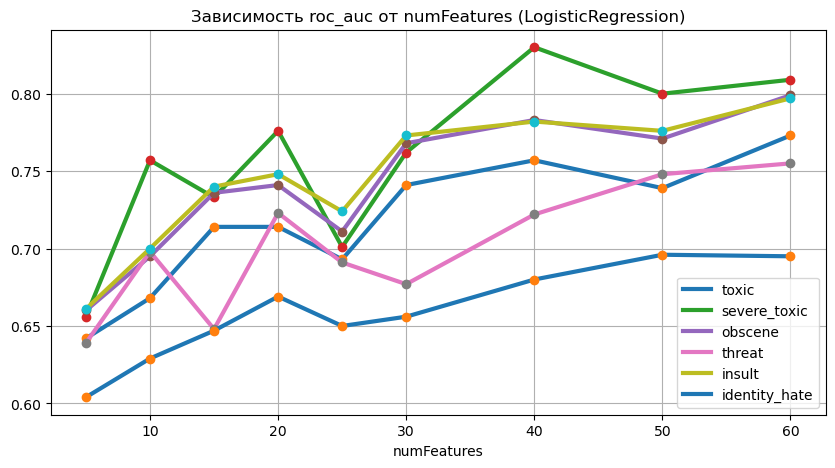

In [ ]:
plot_results(
    dfResLR1.toPandas(), 
    title="Зависимость roc_auc от numFeatures (LogisticRegression)", 
    xlabel="numFeatures"
)

## 3.2. Случайный лес

In [ ]:
# Таблица, куда будем заносить результаты.
dfResRF1 = spark.read.csv("data/df_res.csv", header=True)
dfResRF1.show()

+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|       target|numFeat_5|numFeat_10|numFeat_15|numFeat_20|numFeat_25|numFeat_30|numFeat_40|numFeat_50|numFeat_60|
+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|        toxic|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
| severe_toxic|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|      obscene|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|       threat|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|       insult|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0.0|
|identity_hate|      0.0|       0.0|       0.0|       0.0|       0.0|       0.0|       0

In [ ]:
for numFeatures in [5, 10, 15, 20, 25, 30, 40, 50, 60]:
    
    for targetColumn in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
        
        # train-test split
        trainData, testData = trainTestSplit(df, targetCol=targetColumn, testSize=0.33)

        # pipeline
        model = RandomForestClassifier(
            labelCol=targetColumn, featuresCol="features", numTrees=100
        )
        htf, idf = hashingTFandIDF(numFeatures=numFeatures, inputCol="comment_text_split")
        pipeline = Pipeline(stages=[htf, idf, model])

        rocAuc = train(pipeline=pipeline, trainData=trainData, testData=testData, targetCol=targetColumn)

        # print(f"* NumFeatures = {numFeatures}, TargetColumn = {targetColumn}, RocAuc(Test) = {rocAuc:.4f}")
        
        dfResRF1 = dfResRF1.withColumn(
            f"numFeat_{numFeatures}", 
            when(
                col("target") == targetColumn, 
                rocAuc
            ).otherwise(col(f"numFeat_{numFeatures}"))
        )
        dfResRF1 = dfResRF1.withColumn(f"numFeat_{numFeatures}", round(dfResRF1[f"numFeat_{numFeatures}"], 3))
        

In [ ]:
dfResRF1.show()

+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|       target|numFeat_5|numFeat_10|numFeat_15|numFeat_20|numFeat_25|numFeat_30|numFeat_40|numFeat_50|numFeat_60|
+-------------+---------+----------+----------+----------+----------+----------+----------+----------+----------+
|        toxic|    0.645|     0.659|     0.675|     0.678|     0.664|      0.69|     0.696|     0.697|     0.704|
| severe_toxic|    0.718|     0.756|     0.765|     0.775|     0.757|     0.774|     0.785|      0.78|     0.774|
|      obscene|    0.663|     0.693|     0.701|     0.706|     0.691|     0.721|     0.739|     0.735|     0.742|
|       threat|    0.657|     0.679|     0.682|     0.708|     0.689|     0.702|      0.74|     0.732|     0.719|
|       insult|    0.668|     0.695|      0.71|     0.714|     0.701|     0.734|      0.74|     0.741|     0.751|
|identity_hate|    0.628|     0.649|     0.668|     0.671|     0.669|     0.683|     0.6

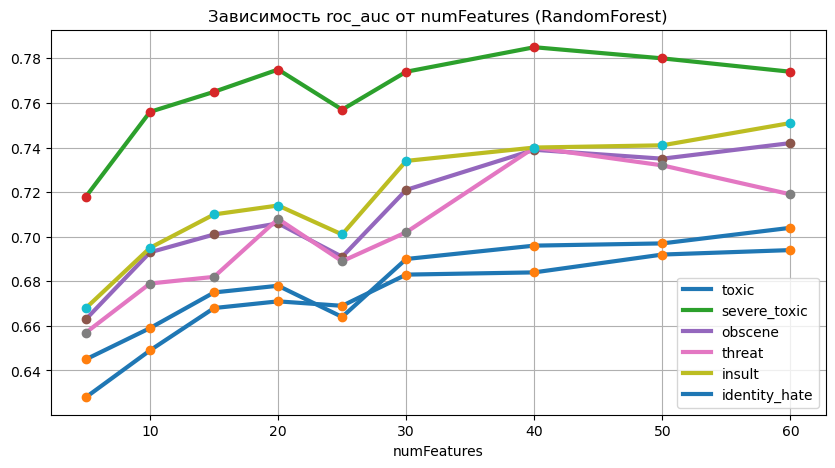

In [ ]:
plot_results(
    dfResRF1.toPandas(), 
    title="Зависимость roc_auc от numFeatures (RandomForest)", 
    xlabel="numFeatures"
)

## 3.3. Выводы

* Случайный лес чуть похуже показал результаты.

* С ростом `numFeatures` качество на тесте (метрика `roc_auc`) растет. При увеличении `numFeatures` c 5 до 60 `roc_auc` вырос для логистической регрессии в среднем на  $0.1\ ..\ 0.15$, а для случайного леса на $0.05\ ..\ 0.1$ для каждого таргета.

* Но здесь вопрос подбора гиперпараметров не рассматривался.

# 4. w2v + Classification Models



> * Будем варьировать `vectorSize` для `word2Vec`, строить модель бинарной классификации для каждого таргета и оценивать метрику `roc_auc` на тестовой выборке.
> * Будут рассмотрены 2 модели: логистическая регрессия и случайный лес.
> * Разбиение на трейн и тест будет осуществляться с учетом сохранения пропорций меток 0 и 1.

## 4.1. LogisticRegression

In [ ]:
# Таблица, куда будем заносить результаты.
dfResLR2 = spark.read.csv("data/df_res2.csv", header=True)
dfResLR2.show()

+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|       target|vecSize_2|vecSize_3|vecSize_5|vecSize_7|vecSize_10|vecSize_15|vecSize_20|vecSize_25|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|        toxic|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
| severe_toxic|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|      obscene|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|       threat|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|       insult|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|identity_hate|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+


In [ ]:
for vectorSize in [2, 3, 5, 7, 10, 15, 20, 25]:
    
    for targetColumn in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
    
        # train-test split
        trainData, testData = trainTestSplit(df, targetCol=targetColumn, testSize=0.33)

        # pipeline
        model = LogisticRegression(
            labelCol=targetColumn, featuresCol="features", 
            maxIter=1000, regParam=0.001, elasticNetParam=0.0001
        )
        w2v = Word2Vec(vectorSize=vectorSize, inputCol="comment_text_split", outputCol="features", seed=42)
        pipeline = Pipeline(stages=[w2v, model])

        rocAuc = train(pipeline=pipeline, trainData=trainData, testData=testData, targetCol=targetColumn)

        # print(f"* VectorSize = {vectorSize}, TargetColumn = {targetColumn}, RocAuc(Test) = {rocAuc:.4f}")
        
        dfResLR2 = dfResLR2.withColumn(
            f"vecSize_{vectorSize}", 
            when(
                col("target") == targetColumn, 
                rocAuc
            ).otherwise(col(f"vecSize_{vectorSize}"))
        )
        dfResLR2 = dfResLR2.withColumn(f"vecSize_{vectorSize}", round(dfResLR2[f"vecSize_{vectorSize}"], 3))
        

In [ ]:
dfResLR2.show()

+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|       target|vecSize_2|vecSize_3|vecSize_5|vecSize_7|vecSize_10|vecSize_15|vecSize_20|vecSize_25|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|        toxic|    0.843|    0.881|    0.887|    0.891|     0.898|     0.905|     0.908|     0.908|
| severe_toxic|    0.932|    0.945|    0.958|    0.963|     0.965|     0.966|     0.967|      0.97|
|      obscene|    0.894|    0.913|    0.915|    0.915|     0.919|     0.919|     0.924|     0.925|
|       threat|    0.797|    0.837|    0.867|    0.869|     0.895|     0.925|     0.928|     0.929|
|       insult|    0.883|    0.905|    0.913|    0.917|     0.921|     0.923|     0.926|     0.926|
|identity_hate|     0.81|    0.893|    0.921|    0.923|     0.917|     0.923|     0.924|     0.926|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+


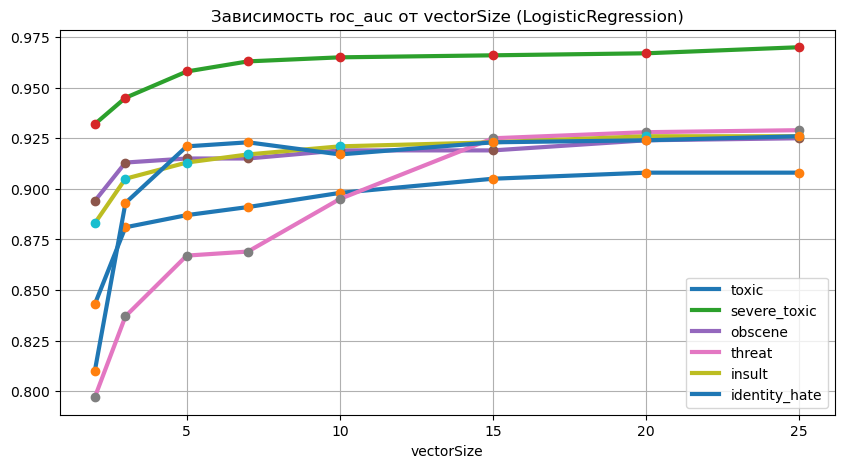

In [7]:
plot_results(
    dfResLR2.toPandas(), 
    title="Зависимость roc_auc от vectorSize (LogisticRegression)", 
    xlabel="vectorSize"
)

## 4.2. RandomForest

In [ ]:
# Таблица, куда будем заносить результаты.
dfResRF2 = spark.read.csv("data/df_res2.csv", header=True)
dfResRF2.show()

+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|       target|vecSize_2|vecSize_3|vecSize_5|vecSize_7|vecSize_10|vecSize_15|vecSize_20|vecSize_25|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|        toxic|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
| severe_toxic|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|      obscene|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|       threat|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|       insult|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
|identity_hate|      0.0|      0.0|      0.0|      0.0|       0.0|       0.0|       0.0|       0.0|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+


In [40]:
for vectorSize in [2, 3, 5, 7, 10, 15, 20, 25]:
    
    for targetColumn in ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]:
        
        # train-test split
        trainData, testData = trainTestSplit(df, targetCol=targetColumn, testSize=0.33)

        # pipeline
        model = RandomForestClassifier(
            labelCol=targetColumn, featuresCol="features", numTrees=100
        )
        w2v = Word2Vec(vectorSize=vectorSize, inputCol="comment_text_split", outputCol="features", seed=42)
        pipeline = Pipeline(stages=[w2v, model])

        rocAuc = train(pipeline=pipeline, trainData=trainData, testData=testData, targetCol=targetColumn)

        # print(f"* VectorSize = {vectorSize}, TargetColumn = {targetColumn}, RocAuc(Test) = {rocAuc:.4f}")
        
        dfResRF2 = dfResRF2.withColumn(
            f"vecSize_{vectorSize}", 
            when(
                col("target") == targetColumn, 
                rocAuc
            ).otherwise(col(f"vecSize_{vectorSize}"))
        )
        dfResRF2 = dfResRF2.withColumn(f"vecSize_{vectorSize}", round(dfResRF2[f"vecSize_{vectorSize}"], 3))
        

In [41]:
dfResRF2.show()

+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|       target|vecSize_2|vecSize_3|vecSize_5|vecSize_7|vecSize_10|vecSize_15|vecSize_20|vecSize_25|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+
|        toxic|    0.772|    0.848|    0.865|     0.86|     0.874|     0.857|     0.858|     0.873|
| severe_toxic|      0.5|    0.796|    0.887|    0.917|     0.917|     0.931|     0.859|     0.915|
|      obscene|    0.758|    0.872|    0.896|    0.889|     0.885|     0.883|     0.887|     0.882|
|       threat|      0.5|    0.706|    0.747|    0.862|     0.836|     0.885|     0.903|     0.858|
|       insult|    0.801|    0.866|    0.863|    0.867|     0.878|     0.881|     0.878|     0.868|
|identity_hate|      0.5|    0.868|      0.9|    0.881|     0.854|      0.87|     0.886|     0.828|
+-------------+---------+---------+---------+---------+----------+----------+----------+----------+


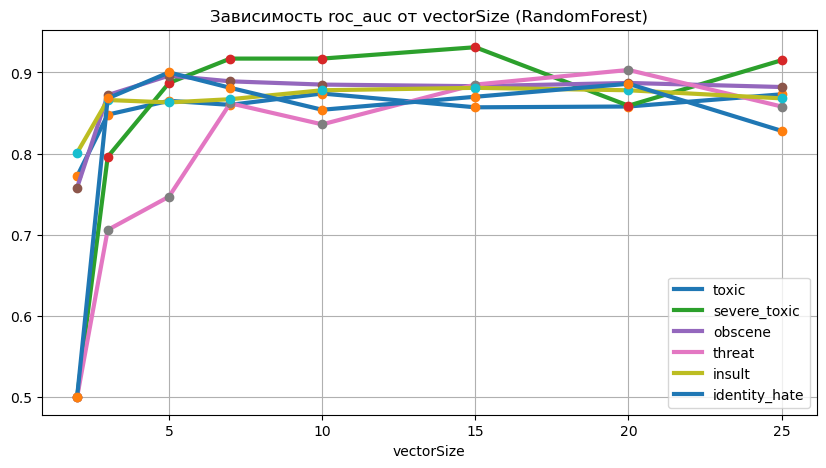

In [9]:
plot_results(
    dfResRF2.toPandas(), 
    title="Зависимость roc_auc от vectorSize (RandomForest)", 
    xlabel="vectorSize"
)

## 4.3. Выводы

* Случайный лес чуть похуже показал результаты.

* С ростом `vectorSize` качество на тесте (метрика `roc_auc`) растет.

* Если сравнивать с `hashingTF`, то `word2Vec` дал лучше результат (уже при `vectorSize = 3`) для метрики `roc_auc` в среднем на $0.1\ ..\ 0.2$. Но из минусов - считается долго.